In [2]:
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import mpl_scatter_density
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.interpolate import griddata
from matplotlib.colors import LogNorm, LinearSegmentedColormap
from matplotlib.lines import Line2D
from datetime import datetime
from cartopy import crs as ccrs

In [3]:
def read_data(root_folder,csv_file):
    df = pd.read_csv(f'{root_folder}/csv/{csv_file}') 
    df = df[df['on_ground'] == False] #Excluding Taxiing Aircraft
    df['x_speed'] = np.sin(np.deg2rad(df['true_track']))*df['velocity']
    df['y_speed'] = np.cos(np.deg2rad(df['true_track']))*df['velocity']
    airspace_state = [(x,y,u,v,speed,country) for x,y,u,v,speed,country in zip(df['longitude'],df['latitude'],df['x_speed'],df['y_speed'],df['velocity'],df['origin_country'])]
    return airspace_state

In [4]:
# Config For Plotting Various Geolocations
plot_config = { 
    "regions" : {
        "eu": {
            "title":"EU Region",
            "set_extent":[-15,30,35,60],
            "headwidth":10,
            "headaxislength":7,
            "headlength":9,
            "width":0.001,
            "scale":20000,
            "x":0.9955,
            "y":0.0085
        },
        "us": {
            "title":"US Region",
            "set_extent":[-128,-65,22,52], 
            "headwidth":10,            
            "headaxislength":5,
            "headlength":8,
            "width":0.0025,
            "scale":35000,
            "x":0.9955,
            "y":0.0095
        }
    }
}
region_config = plot_config['regions']['us']

In [18]:
date_selection = '2024-04-28'
root_folder = f'{os.path.dirname(sys.path[0])}/data/get_states/{date_selection}'
file_list = []
for csv_file in os.listdir(f'{root_folder}/csv'):
    if '.csv' in csv_file:
        timestamp = csv_file.split('.')[0]
        file_list.append((timestamp,csv_file))
timestamp = file_list[1][0]
csv_file = file_list[1][1]
airspace_state = read_data(root_folder,csv_file)

In [6]:
# Getting Sample Airspace States
airspace_state[1]
df = pd.DataFrame(airspace_state,columns=['x','y','u','v','speed','country'])

In [7]:
# Filtering Data To Desired Airspace Boundary
set_extent = [-128,-65,22,52]
filtered_airspace = df[(df['x']>=set_extent[0]) & (df['x']<=set_extent[1]) & (df['y']>=set_extent[2]) & (df['y']<=set_extent[3])]

In [8]:
# Zipping Filtered Aircraft Coordinates and Speeds
xy = list(zip(filtered_airspace['x'],filtered_airspace['y']))
uv = list(zip(filtered_airspace['u'],filtered_airspace['v']))
u = filtered_airspace['u']
v = filtered_airspace['v']
speed = filtered_airspace['speed']
ones = [1 for i in range(len(xy))] # For Density Plot

In [21]:
# Creating Regular Grid Intervals For the x and y Directions
grid_interval = 0.1
step_x = np.arange(set_extent[0],set_extent[1]+1,grid_interval)
step_y = np.arange(set_extent[2],set_extent[3]+1,grid_interval)

In [22]:
# Creating A Mesh Grid Based on the Intervals Created Earlier
grid_x,grid_y = np.meshgrid(step_x,step_y)

In [23]:
# Interpolating the speed values onto the Grid
interp_method = 'linear'
u_grid = griddata(xy, u, (grid_x,grid_y), method=interp_method)
v_grid = griddata(xy, v, (grid_x,grid_y), method=interp_method)
speed_grid = griddata(xy, speed, (grid_x,grid_y), method=interp_method)
density_grid = griddata(xy, ones, (grid_x,grid_y), method=interp_method)
for grid_value in [u_grid,v_grid,speed_grid,density_grid]:
    grid_value[np.isnan(grid_value)] = 0 # Replace NaN's with zero value

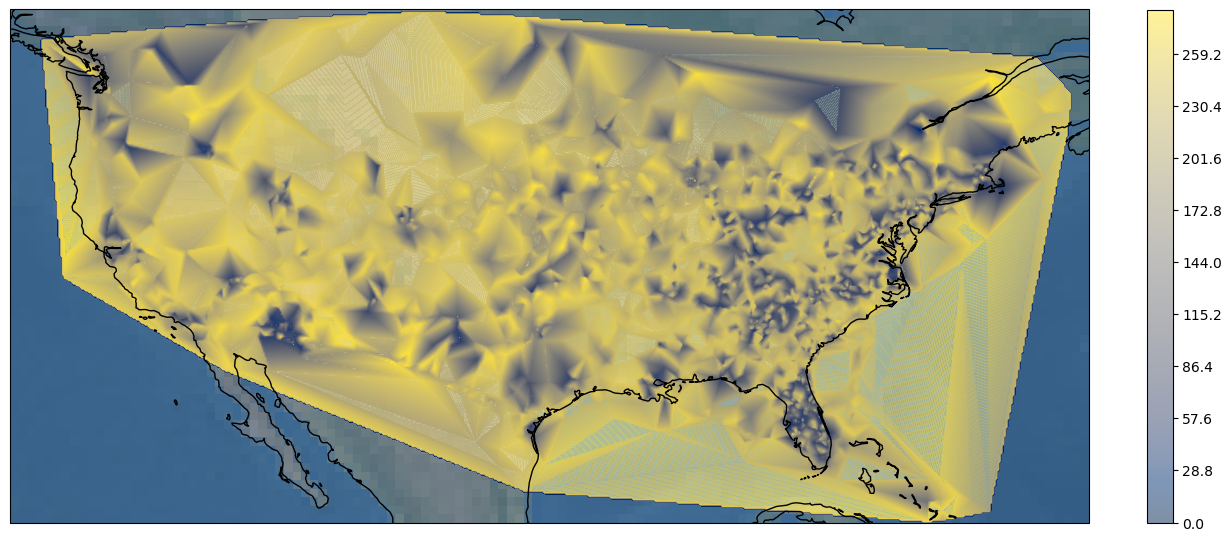

In [30]:
# fig, ax = plt.subplots(figsize =(15,9),num=1,clear=True,layout='constrained')
plt.figure(figsize =(15,9),num=1,clear=True)
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.stock_img()
im = ax.contourf(grid_x,grid_y,speed_grid,levels=500,alpha=0.5,cmap='cividis')
ax.set_extent(region_config.get('set_extent'), crs=ccrs.PlateCarree())
im_ratio = speed_grid.shape[0]/speed_grid.shape[1]*0.0455
plt.colorbar(im,fraction=im_ratio)